# Modelització

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

In [12]:
pd.set_option('display.width', 150)
np.set_printoptions(linewidth=150)

np.random.seed(42)

### Training i test split

In [13]:
X_train = pd.read_csv('X_train.csv', index_col=[0,1])
X_test = pd.read_csv('X_test.csv', index_col=[0,1])
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

In [14]:
X_train.head(2)

,,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,duration,taylors_version,...,Red,Red (Taylor's Version),Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist
name,album,,,,,,,,,,,,,,,,,,,,,
"You're On Your Own, Kid",Midnights,2.148969,-0.779037,0.689602,0.322115,-3.962381,0.399829,0.372703,0.389355,0.102381,False,...,False,False,False,False,False,False,False,False,False,False
Fearless,Fearless,2.768934,-2.302505,0.542813,0.716346,-1.666484,0.822298,0.228743,0.474382,0.204814,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
y_train.to_frame().T

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
popularity,0.67,0.43,0.78,0.65,0.54,0.69,0.51,0.79,0.3,0.33,...,0.33,0.5,0.54,0.68,0.71,0.64,0.71,0.76,0.45,0.7


### Useful Functions

In [16]:
def compute_metrics(y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mean_abs_e = mean_absolute_error(y_test, y_pred)
    median_abs_e = median_absolute_error(y_test, y_pred)
    return r2, mse, mean_abs_e, median_abs_e

In [17]:
def plot_predictions(model, plot=True):
    y_pred = model.predict(X_test)

    if hasattr(model, 'oob_score_'):
        print(f'OOB Score:      {model.oob_score_:.4f}')

    r2, mse, mean_abs_e, median_abs_e = compute_metrics(y_pred)
    print(f'r2 score:       {r2:.4f}\n' +
          f'mse:            {mse:.4f}\n' +
          f'mean abs err:   {mean_abs_e:.4f}\n' +
          f'median abs err: {median_abs_e:.4f}')
    
    if not plot:
        return

    predictions_df = pd.DataFrame({'popularity': y_test.values, 'y_pred': y_pred}, index=X_test.index)
    album_names = predictions_df.index.get_level_values(1).unique()

    for album in album_names:
        subset = predictions_df[predictions_df.index.get_level_values(1) == album]
        plt.scatter(subset['popularity'], subset['y_pred'], label=album, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='black', alpha=0.5, ls=':')
    plt.xlim(0.25, 0.95)
    plt.ylim(0.25, 0.95)
    plt.xlabel("Real popularity")
    plt.ylabel("Predicted popularity")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [18]:
def bar_importances(weights, intercept=None):
    df = pd.DataFrame(weights, index=X_train.columns, columns=['importance'])
    
    if intercept is not None:
        df.loc['intercept'] = intercept

    df['abs_importance'] = df['importance'].abs()
    df = df.sort_values(by='abs_importance', ascending=False)
    df = df.drop(columns='abs_importance')

    df.index = np.where(df.index.str.len() > 15, df.index.str.slice(0, 15) + '...', df.index)
    plt.figure(figsize=(14, 4))
    plt.bar(df.index, df['importance'])
    plt.axhline(0, color='black', lw=0.8)
    plt.xticks(rotation=90)
    plt.show()

## Linear Models

In [9]:
from sklearn.linear_model import LinearRegression,  RidgeCV, LassoCV

In [10]:
lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

weights = lr.coef_
intercept = lr.intercept_

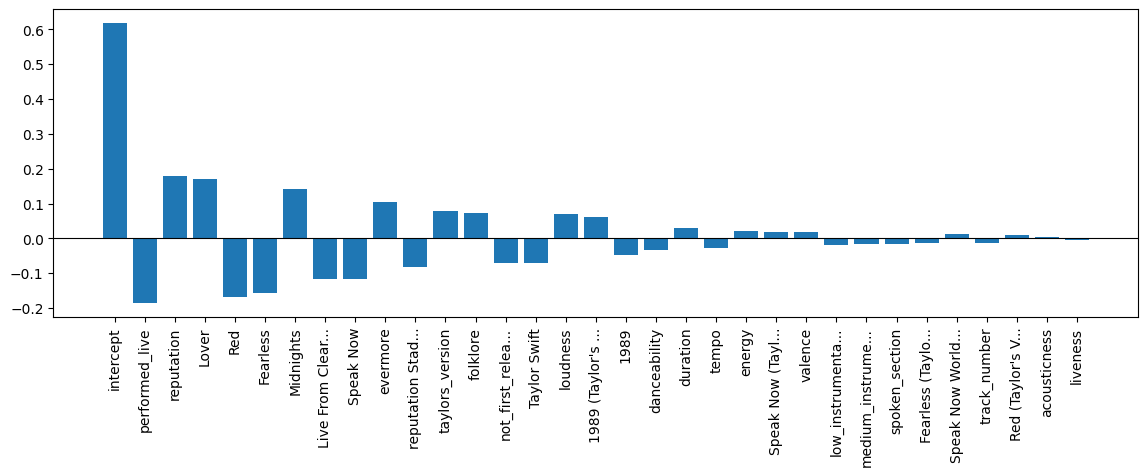

In [114]:
bar_importances(weights, intercept)

Molt important veure quins són els pesos dels coeficients 'album', ja que per predir futurs àlbums no s'ha de posar

In [12]:
album_idx = 15

df = pd.DataFrame(weights[album_idx:], index=X_train.columns[album_idx:], columns=['coef.']).T
df['intercept'] = intercept
df

,1989,1989 (Taylor's Version),Fearless,Fearless (Taylor's Version),Live From Clear Channel Stripped 2008,Lover,Midnights,Red,Red (Taylor's Version),Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist,intercept
coef.,-0.048798,0.063077,-0.157756,-0.013935,-0.117577,0.170242,0.141448,-0.166739,0.010846,-0.116359,0.018538,0.01337,-0.070404,0.10403,0.072758,0.179455,-0.082194,0.617458


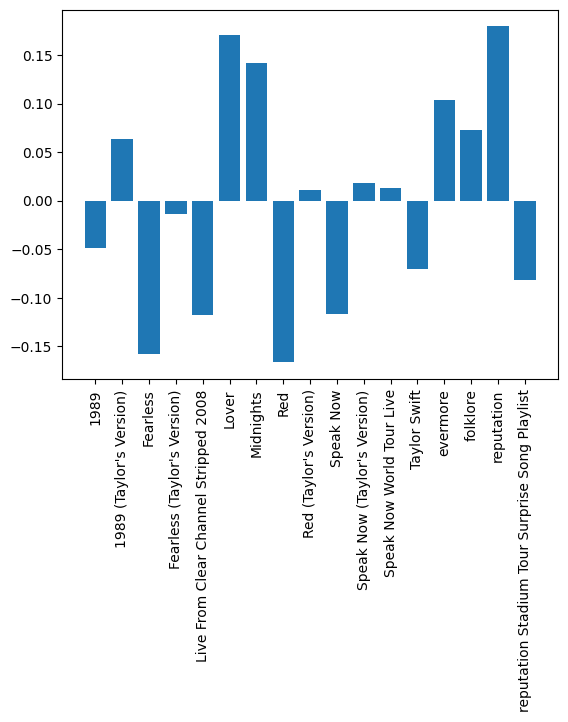

In [13]:
plt.bar(X_test.columns[album_idx:], weights[album_idx:])
plt.xticks(rotation=90)
plt.show()

Veiem que els àlbums més recents (Midnights, evermore, folklore, Lover) tenen pesos positius
També veiem que els àlbuls els quals tenen un album amb Taylor version, tene pesos molt negatius.

r2 score:       0.8256
mse:            0.0033
mean abs err:   0.0432
median abs err: 0.0347


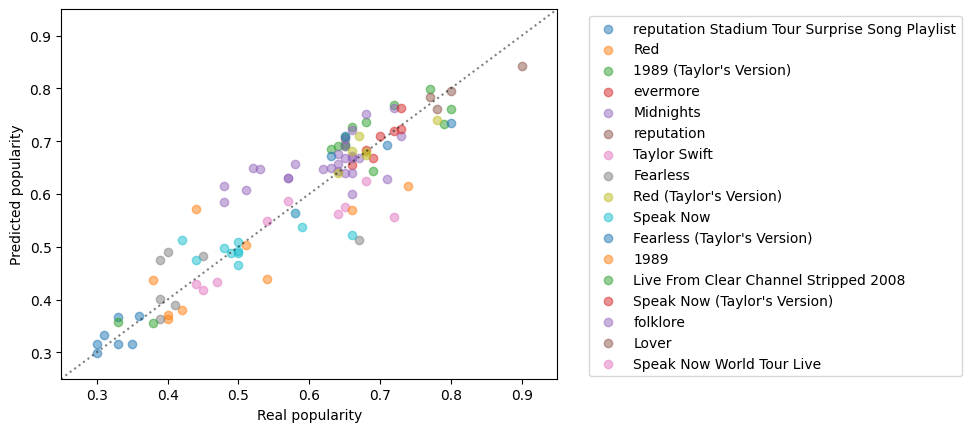

In [14]:
plot_predictions(lr)

Veiem que el model lineal de moment explica molta variablitat.

### Ridge

In [15]:
lambdas = [0.01, 0.1, 1, 10, 1e2, 1e3]

Best Lambda: 0.8
r2 score:       0.8333
mse:            0.0031
mean abs err:   0.0419
median abs err: 0.0334


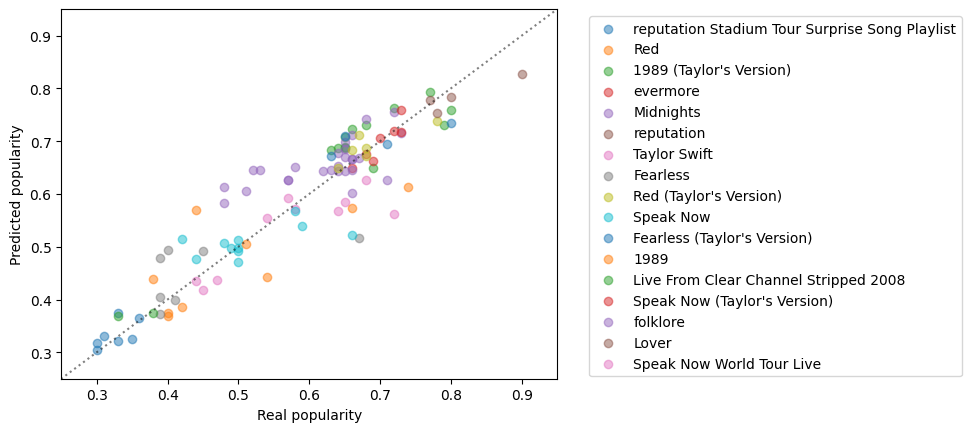

In [97]:
ridge_cv = RidgeCV(alphas=lambdas, cv=5)
ridge_cv.fit(X_train, y_train)
print('Best Lambda:', ridge_cv.alpha_)
plot_predictions(ridge_cv)

In [91]:
np.mean(np.abs(ridge_cv.coef_ - lr.coef_)) # We compare the magnitud of the coefficients

0.007673556132274126

### Lasso

In [18]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [95]:
lasso_cv = LassoCV(alphas=lambdas, cv=5, max_iter=10_000_000)
lasso_cv.fit(X_train, y_train)
print('Best Lambda:', lasso_cv.alpha_)
plot_predictions(lasso_cv, plot=False)

Best Lambda: 0.0001
r2 score:       0.8316
mse:            0.0031
mean abs err:   0.0419
median abs err: 0.0337


In [93]:
np.mean(abs(lasso_cv.coef_ - lr.coef_)) # We compare the magnitud of the coefficients. Here, there's a more significant difference

0.014413067272102653

Hi ha una mica més de diferència

## Decision Tree and Random Forest

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

### Decision Tree

In [23]:
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

In [51]:
param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None],
    'criterion': ['squared_error'],
    'splitter': ['random'],
    'max_leaf_nodes': [15, 20, 25],
    'min_impurity_decrease': [0.0]
}

dt = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_

In [52]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_r2,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error
95,10,5,4,None,0.847769,-0.045488,-0.003604
94,10,4,4,None,0.847769,-0.045488,-0.003604
93,10,3,4,None,0.847769,-0.045488,-0.003604
92,10,2,4,None,0.847769,-0.045488,-0.003604
76,10,2,4,None,0.845665,-0.045544,-0.003655


r2 score:       0.8035
mse:            0.0037
mean abs err:   0.0435
median abs err: 0.0290


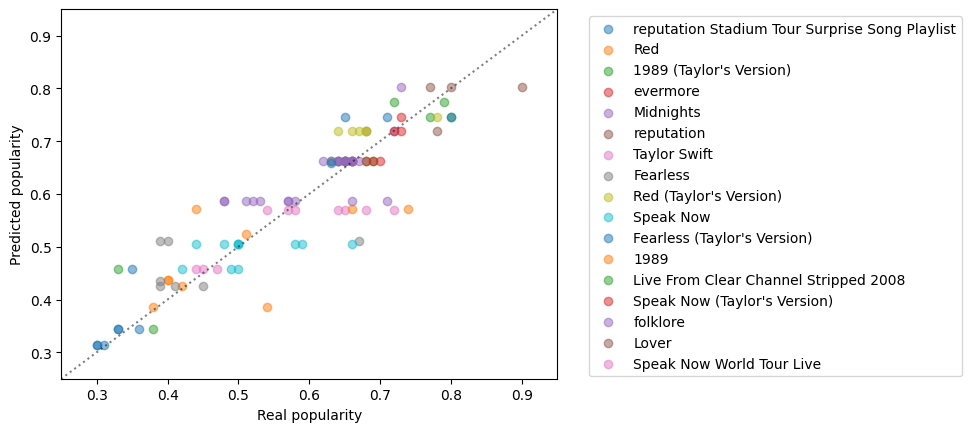

In [53]:
plot_predictions(best_dt)

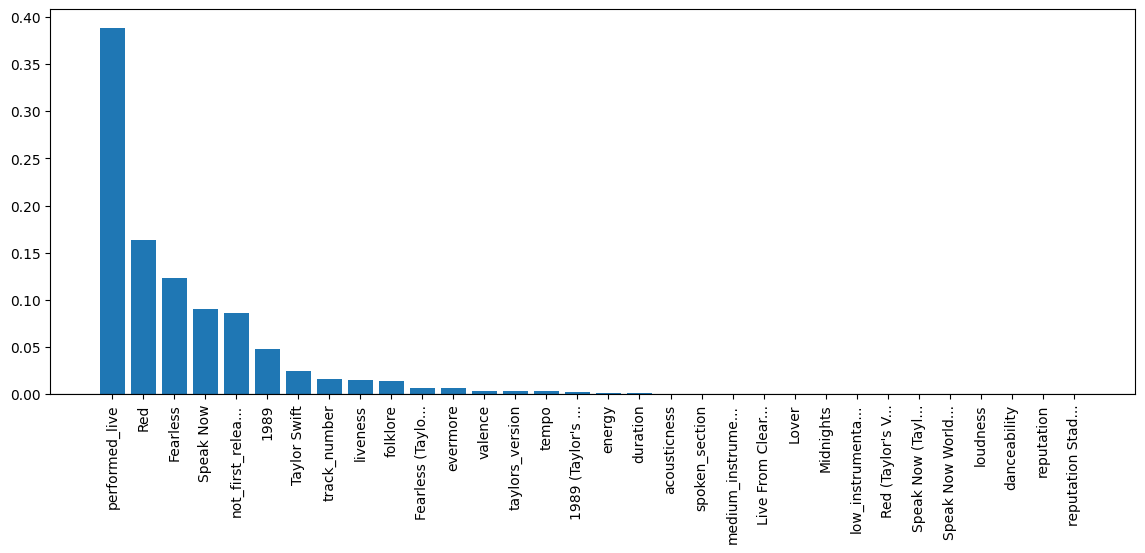

In [112]:
bar_importances(best_dt.feature_importances_)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 9],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3],
    'max_features': [None, 'log2', 'sqrt'],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit='r2', return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [88]:
scoring_cols = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', #'param_criterion', 'param_max_leaf_nodes', 'param_min_impurity_decrease',
    'mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_r2,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error
4,100,8,5,2,None,0.834778,-0.047957,-0.003930
40,100,9,5,2,None,0.834650,-0.047456,-0.003934
5,200,8,5,2,None,0.834384,-0.047900,-0.003939
1,200,8,2,2,None,0.834266,-0.047972,-0.003941
3,200,8,3,2,None,0.834266,-0.047972,-0.003941


OOB Score:      0.8448
r2 score:       0.7944
mse:            0.0038
mean abs err:   0.0454
median abs err: 0.0344


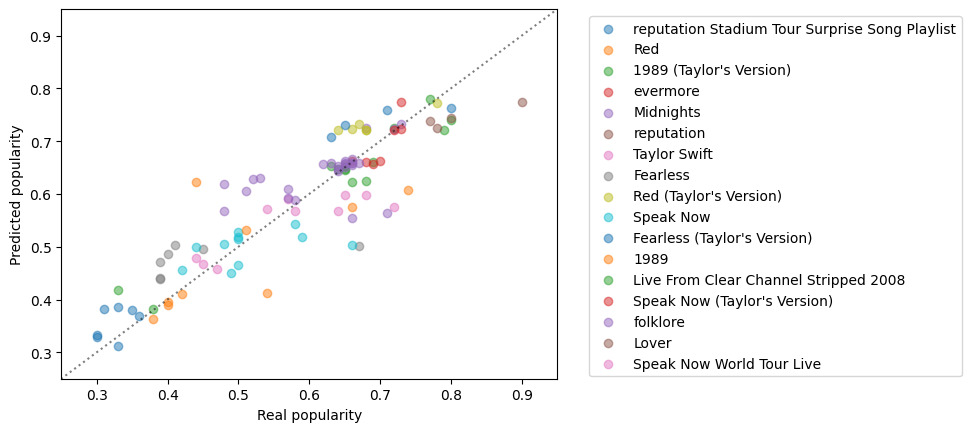

In [89]:
best_rf = RandomForestRegressor(oob_score=True,random_state=42,**best_params)
best_rf.fit(X_train, y_train)
plot_predictions(best_rf)

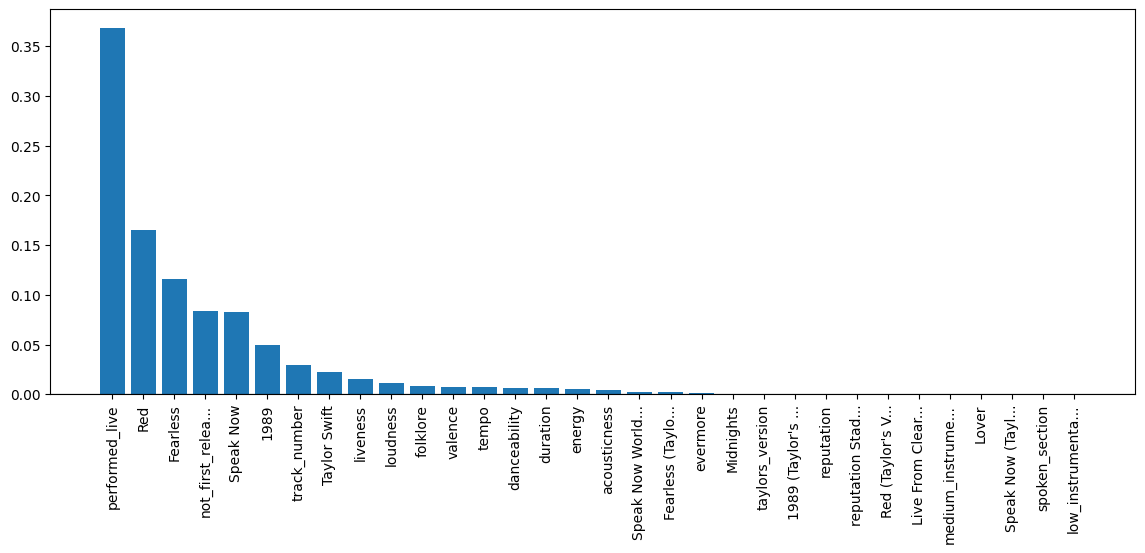

In [108]:
bar_importances(best_rf.feature_importances_)

## Boosting

We combine boosting with gridsearch to obtain the best estimators possible

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

In [44]:
scoring_cols = ['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_loss', 'param_subsample', 'param_max_features', 'mean_train_score', 'mean_test_score']
results_df = pd.DataFrame(columns=scoring_cols)
results_df = results_df.astype({
    'param_n_estimators': 'int32',
    'param_learning_rate': 'float64',
    'param_max_depth': 'int32',
    'param_min_samples_split': 'int32',
    'param_min_samples_leaf': 'int32',
    'param_loss': 'string',
    'param_subsample': 'float64',
    'param_max_features': 'object',
    'mean_train_score': 'float64',
    'mean_test_score': 'float64'
})

In [45]:
param_grid = {
    'n_estimators': [150, 200],
    'learning_rate': [0.1],
    'max_depth': [1, 2],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [4, 5, 6],
    'loss': ['squared_error', 'huber'],
    'subsample': [1.0],
    'max_features': [None]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, refit='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_

new_results = pd.DataFrame(grid_search.cv_results_)[scoring_cols]
results_df = pd.concat([results_df, new_results], ignore_index=True).drop_duplicates()

In [46]:
results_df.sort_values(by='mean_test_score', ascending=False).head(10)

,param_n_estimators,param_learning_rate,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_loss,param_subsample,param_max_features,mean_train_score,mean_test_score
37,200,0.1,2,2,4,huber,1.0,None,0.925708,0.838176
39,200,0.1,2,3,4,huber,1.0,None,0.925708,0.838176
15,200,0.1,2,3,4,squared_error,1.0,None,0.930092,0.834983
13,200,0.1,2,2,4,squared_error,1.0,None,0.930092,0.834983
38,150,0.1,2,3,4,huber,1.0,None,0.909654,0.834316
36,150,0.1,2,2,4,huber,1.0,None,0.909654,0.834316
23,200,0.1,2,3,6,squared_error,1.0,None,0.928760,0.834048
21,200,0.1,2,2,6,squared_error,1.0,None,0.928760,0.834048
14,150,0.1,2,3,4,squared_error,1.0,None,0.912987,0.832304
12,150,0.1,2,2,4,squared_error,1.0,None,0.912987,0.832304


We see that there is a bunch of overfitting. (since the train score is much higher thatn the test score)

{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'loss': 'huber', 'subsample': 1.0, 'max_features': None}
r2 score:       0.8370
mse:            0.0030
mean abs err:   0.0400
median abs err: 0.0245


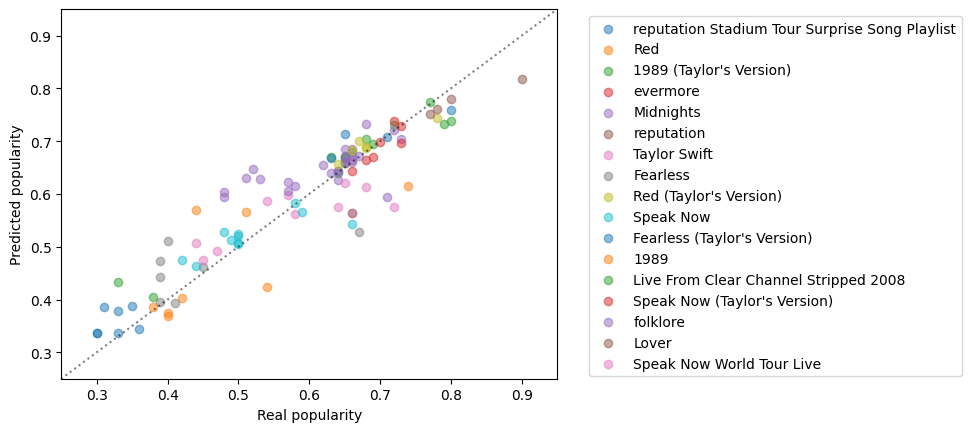

In [47]:
best_gb_params = results_df.loc[[results_df['mean_test_score'].idxmax()]]
best_gb_params = best_gb_params.drop(['mean_test_score', 'mean_train_score'], axis=1)
best_gb_params_dict = best_gb_params.iloc[0,:].to_dict()
best_gb_params_dict = {k.replace('param_', ''): v for k, v in best_gb_params_dict.items()}
print(best_gb_params_dict)
best_gb = GradientBoostingRegressor(**best_gb_params_dict)
best_gb.fit(X_train, y_train)
plot_predictions(best_gb)

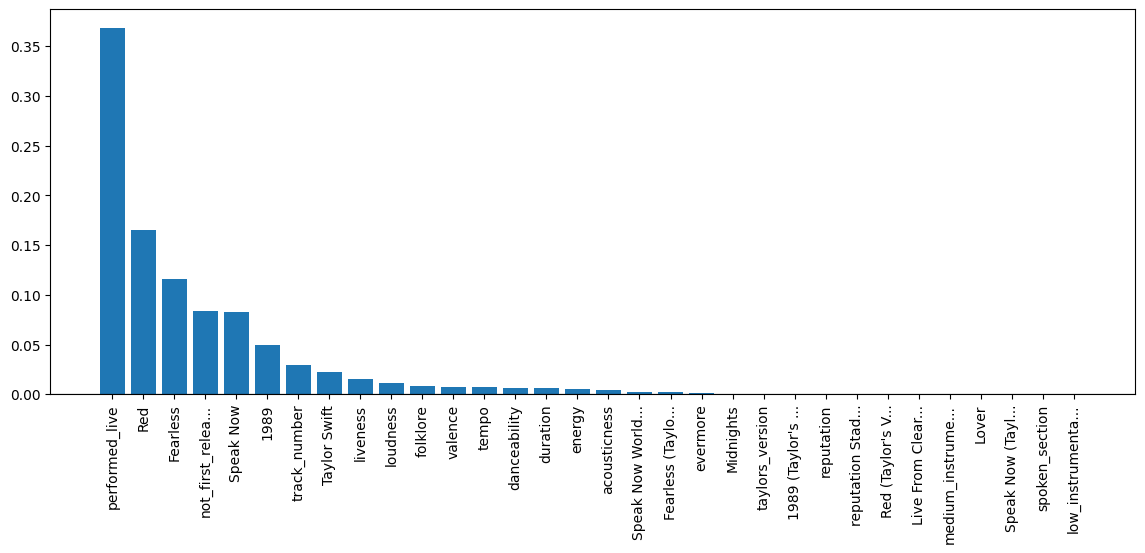

In [111]:
importances = grid_search.best_estimator_.feature_importances_
bar_importances(importances)

we can see that performed live is very important, and that not_first_release is also pretty important. Some albums are much more important than others.

## SVM

In [19]:
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor

In [20]:
results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Baseline el KNN

r2 score:       0.6345
mse:            0.0068
mean abs err:   0.0641
median abs err: 0.0490


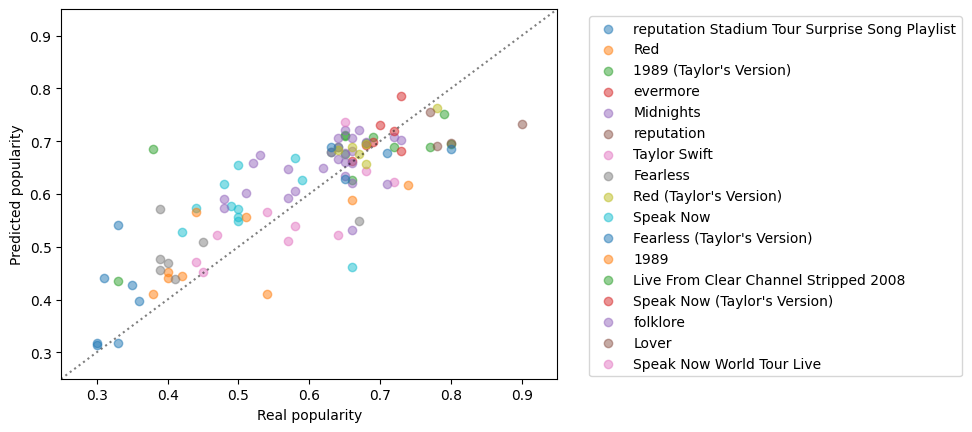

In [21]:
knn = KNeighborsRegressor()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

plot_predictions(knn)

results.loc['KNN', :] = ['-', '-','-'] + list(compute_metrics(y_pred))

### Linear SVM

r2 score:       0.7890
mse:            0.0039
mean abs err:   0.0433
median abs err: 0.0269


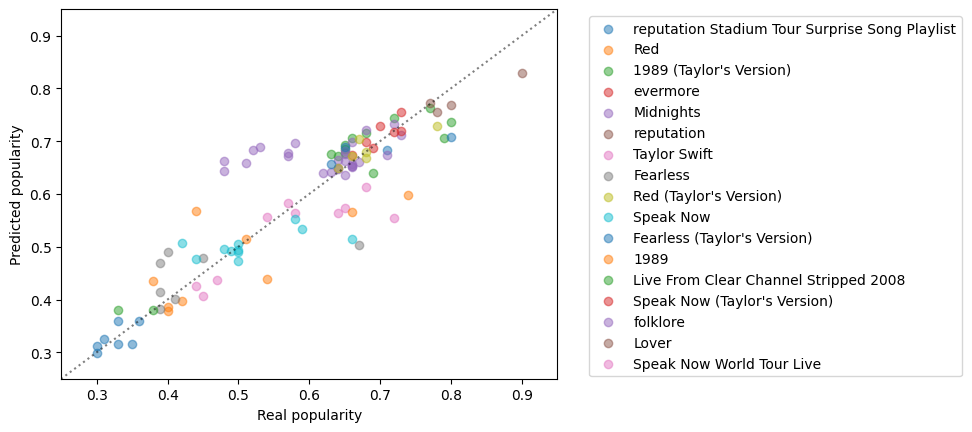

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-default,linear,1,0,0.789012,0.003937,0.043316,0.026931
KNN,-,-,-,0.634528,0.00682,0.064094,0.049


In [22]:
svm = LinearSVR(dual=True, max_iter=100000)

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

results.loc['LinearSVR-default', :] = ['linear',1,0] + list(compute_metrics(y_pred))

plot_predictions(svm)

results.sort_values(by='R2', ascending=False)

SVM with parameters "gridsearch"?

In [23]:
cv_results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Cs = [5, 10, 15, 20, 30] # values less than 10
epsilons = [0.0001, 0.00001, 0.000001, 0.0000001, 0.0]
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel='linear', C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = svm.predict(X_test)
        cv_results.loc['LinearSVR-{}-{}'.format(c,epsilon), :] = ['linear', c, epsilon] + list(compute_metrics(y_pred))
        
best = cv_results.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc['LinearSVR-best',:] = best

In [24]:
cv_results.sort_values(by='R2', ascending=False).head()

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-5-1e-06,linear,5,0.000001,0.794292,0.003839,0.042884,0.025283
LinearSVR-5-1e-07,linear,5,0.0,0.794231,0.00384,0.042845,0.025549
LinearSVR-20-1e-07,linear,20,0.0,0.79416,0.003841,0.042762,0.025469
LinearSVR-20-1e-06,linear,20,0.000001,0.794149,0.003842,0.042819,0.025917
LinearSVR-15-1e-07,linear,15,0.0,0.793888,0.003846,0.042854,0.025747


In [25]:
results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-best,linear,5,0.000001,0.794292,0.003839,0.042884,0.025283
LinearSVR-default,linear,1,0,0.789012,0.003937,0.043316,0.026931
KNN,-,-,-,0.634528,0.00682,0.064094,0.049


r2 score:       0.7943
mse:            0.0038
mean abs err:   0.0429
median abs err: 0.0253


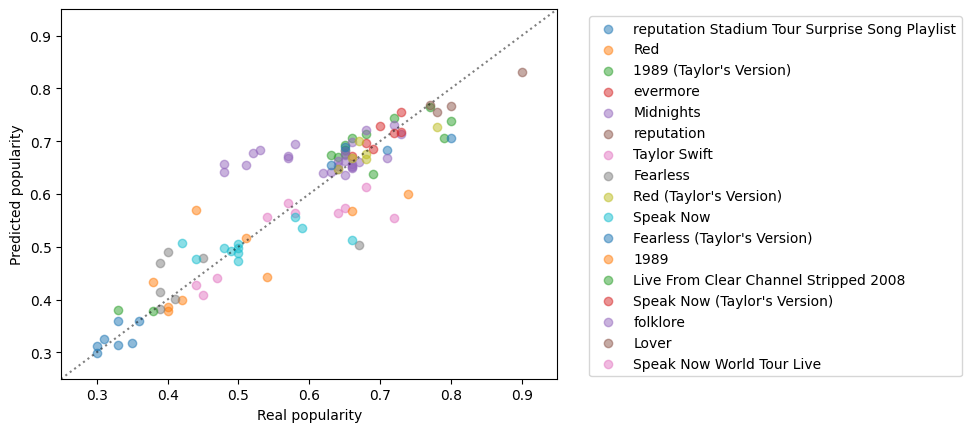

In [26]:
svm_best = SVR(kernel='linear', C=best['C'], epsilon=best['epsilon'])
svm_best.fit(X_train,y_train)
plot_predictions(svm_best)

### Non-linear SVR

In [27]:
Cs = [1, 5, 15, 20, 25]
epsilons = [0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001, 0.00001, 0, 0]
for kernel_type in ['rbf', 'sigmoid', 'poly']:
    
    svr = SVR(kernel=kernel_type)
    svr.fit(X_train,y_train)
    y_pred = svr.predict(X_test)

    results.loc[kernel_type+'-SVR-default', :] = [kernel_type,1,0] + list(compute_metrics(y_pred))
    
    cv_results_rbf = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])
    for c in Cs:
        for epsilon in epsilons:
            svm = SVR(kernel=kernel_type, C=c,epsilon=epsilon)
            svm.fit(X_train,y_train)
            y_pred = svm.predict(X_test)
            cv_results_rbf.loc[kernel_type+'SVR-{}-{}'.format(c,epsilon), :] = [kernel_type, c, epsilon] + list(compute_metrics(y_pred))
            
    best = cv_results_rbf.sort_values(by='R2',ascending=False).iloc[0,:]
    results.loc[kernel_type+'SVR-best',:] = best

results.sort_values(by='R2', ascending=False).head(10)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,15,0.02,0.826019,0.003247,0.04058,0.028849
polySVR-best,poly,25,0.005,0.801024,0.003713,0.043624,0.028712
LinearSVR-best,linear,5,0.000001,0.794292,0.003839,0.042884,0.025283
LinearSVR-default,linear,1,0,0.789012,0.003937,0.043316,0.026931
rbf-SVR-default,rbf,1,0,0.759746,0.004484,0.05486,0.049076
poly-SVR-default,poly,1,0,0.654935,0.00644,0.064736,0.052626
KNN,-,-,-,0.634528,0.00682,0.064094,0.049
sigmoid-SVR-default,sigmoid,1,0,-151.7082,2.849801,1.322918,1.100056
sigmoidSVR-best,sigmoid,1,0.1,-151.7082,2.849801,1.322918,1.100056


r2 score:       0.8260
mse:            0.0032
mean abs err:   0.0406
median abs err: 0.0288


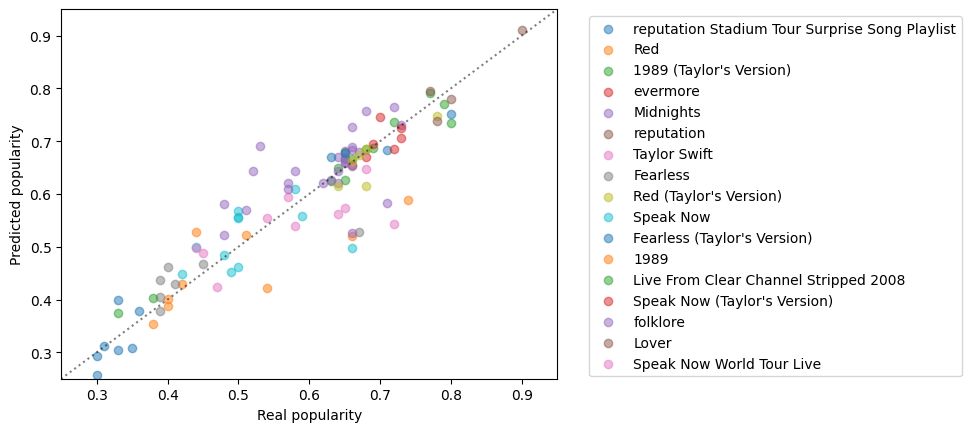

In [28]:
best_svm_params = results.loc[[results['R2'].idxmax()]]
best_svm_all = SVR(kernel=best_svm_params['Kernel'].values[0], C=best_svm_params['C'].values[0], epsilon=best_svm_params['epsilon'].values[0])
best_svm_all.fit(X_train,y_train)
plot_predictions(best_svm_all)